# Anomaly Detection - air_12300

This notebook applies anomaly detection to air_12300 using:
1. Isolation Forest (unsupervised)
2. One-Class SVM (unsupervised)
3. Heuristic rules (domain-based)

Results are combined using a voting scheme.

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Load engineered features
df = pd.read_parquet("../../data/processed/air_12300_features_full.parquet")

if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
else:
    raise KeyError("⚠️ 'time' is missing from features file. Check FeatureEngineering notebook.")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()[:10]}...")

Dataset shape: (509084, 46)
Columns: ['time', 'id', 'epoch', 'air', 'device', 'freq_Hz*10', 'vlineavg_V', 'va_V', 'vb_V', 'vc_V']...


In [2]:
# Focus only on ON cycles
df_on = df[df['is_running'] == 1].copy()
print(f"Data shape (ON cycles): {df_on.shape}")

# Select feature columns (drop ID/time-like fields)
feature_cols = [c for c in df_on.columns if c not in ['time', 'id', 'is_running']]
X = df_on[feature_cols].fillna(0).values

print(f"Feature matrix shape: {X.shape}")

Data shape (ON cycles): (502117, 46)
Feature matrix shape: (502117, 43)


In [3]:
# Ensure pf_anomaly exists
if 'pf_anomaly' not in df_on.columns:
    if 'pftot_None' in df_on.columns:
        df_on['pf_anomaly'] = np.abs(1 - df_on['pftot_None'])
    elif all(c in df_on.columns for c in ['ia_A', 'ib_A', 'ic_A', 'ptot_W']):
        total_current = df_on[['ia_A', 'ib_A', 'ic_A']].sum(axis=1).replace(0, np.nan)
        df_on['pf_est'] = df_on['ptot_W'] / (np.sqrt(3) * 400 * total_current)
        df_on['pf_anomaly'] = 1 - df_on['pf_est'].clip(0, 1).fillna(1)
    else:
        df_on['pf_anomaly'] = np.nan

# Ensure fuel_%_roc exists
if 'fuel_%_roc' not in df_on.columns and 'fuel_%' in df_on.columns:
    df_on['fuel_%_roc'] = df_on['fuel_%'].diff().fillna(0)

print("✓ Feature checks completed")

✓ Feature checks completed


## 2. Unsupervised Anomaly Detection

### Isolation Forest

In [4]:
# Isolation Forest
iso = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
df_on['anomaly_iforest'] = iso.fit_predict(X)

# Convert to 0=normal, 1=anomaly
df_on['anomaly_iforest'] = (df_on['anomaly_iforest'] == -1).astype(int)
print(f"IForest anomalies: {df_on['anomaly_iforest'].sum()}")

IForest anomalies: 5022


### One-Class SVM

In [5]:
# One-Class SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ocsvm = OneClassSVM(nu=0.01, kernel="rbf", gamma="scale")
df_on['anomaly_ocsvm'] = ocsvm.fit_predict(X_scaled)
df_on['anomaly_ocsvm'] = (df_on['anomaly_ocsvm'] == -1).astype(int)

print(f"OC-SVM anomalies: {df_on['anomaly_ocsvm'].sum()}")

OC-SVM anomalies: 8476


## 3. Heuristic Anomaly Detection

In [6]:
# Improved Heuristic Model
df_h = df_on.copy()

# Rolling window (fixed number of samples to avoid errors)
ROLL_WINDOW = 20

# Compute rolling features safely
if 'temp_Degrees Celsius' in df_h.columns:
    df_h['temp_roll_mean'] = df_h['temp_Degrees Celsius'].rolling(ROLL_WINDOW, min_periods=1).mean()

if 'ptot_W' in df_h.columns:
    df_h['ptot_W_rollstd'] = df_h['ptot_W'].rolling(ROLL_WINDOW, min_periods=1).std()

if 'fuel_%' in df_h.columns:
    df_h['fuel_%_roc'] = df_h['fuel_%'].diff().fillna(0)

if all(c in df_h.columns for c in ['ia_A', 'ib_A', 'ic_A']):
    df_h['current_imbalance'] = df_h[['ia_A', 'ib_A', 'ic_A']].std(axis=1)

if all(c in df_h.columns for c in ['va_V', 'vb_V', 'vc_V']):
    df_h['voltage_imbalance'] = df_h[['va_V', 'vb_V', 'vc_V']].std(axis=1)

print("✓ Rolling features computed")

✓ Rolling features computed


In [7]:
# Thresholds
def pct_thresh(series, pct):
    series = series.dropna()
    return series.quantile(pct) if len(series) > 0 else np.nan

th_temp = pct_thresh(df_h['temp_Degrees Celsius'], 0.995) if 'temp_Degrees Celsius' in df_h else np.nan
th_pf = pct_thresh(df_h['pf_anomaly'], 0.99) if 'pf_anomaly' in df_h else np.nan
th_fuel = pct_thresh(df_h['fuel_%_roc'], 0.01) if 'fuel_%_roc' in df_h else np.nan
th_curr = pct_thresh(df_h['current_imbalance'], 0.99) if 'current_imbalance' in df_h else np.nan
th_volt = pct_thresh(df_h['voltage_imbalance'], 0.99) if 'voltage_imbalance' in df_h else np.nan

print(f"Thresholds:")
print(f"  Temperature: {th_temp:.2f}°C")
print(f"  Power factor anomaly: {th_pf:.4f}")
print(f"  Fuel rate: {th_fuel:.2f}%")
print(f"  Current imbalance: {th_curr:.2f}A")
print(f"  Voltage imbalance: {th_volt:.2f}V")

Thresholds:
  Temperature: 2000000000.00°C
  Power factor anomaly: 1999999999.0000
  Fuel rate: nan%
  Current imbalance: 1154700538.38A
  Voltage imbalance: 1154700538.38V


In [8]:
# Apply rules
scores = pd.DataFrame(index=df_h.index)
scores['temp'] = (df_h['temp_Degrees Celsius'] > th_temp).astype(int) if 'temp_Degrees Celsius' in df_h else 0
scores['pf'] = (df_h['pf_anomaly'] > th_pf).astype(int) if 'pf_anomaly' in df_h else 0
scores['fuel'] = (df_h['fuel_%_roc'] < th_fuel).astype(int) if 'fuel_%_roc' in df_h else 0
scores['curr'] = (df_h['current_imbalance'] > th_curr).astype(int) if 'current_imbalance' in df_h else 0
scores['volt'] = (df_h['voltage_imbalance'] > th_volt).astype(int) if 'voltage_imbalance' in df_h else 0

# Heuristic anomaly score
df_h['heuristic_score'] = scores.sum(axis=1) / max(1, scores.shape[1])

# Binary anomaly flag
df_h['anomaly_heuristic'] = (df_h['heuristic_score'] >= 0.4).astype(int)

# Update df_on
df_on['heuristic_score'] = df_h['heuristic_score']
df_on['anomaly_heuristic'] = df_h['anomaly_heuristic']

print(f"✅ Heuristic anomalies: {df_on['anomaly_heuristic'].sum()}")

✅ Heuristic anomalies: 127


## 4. Voting Ensemble

In [9]:
methods = ['anomaly_iforest', 'anomaly_ocsvm', 'anomaly_heuristic']

def ensure_anomaly_votes(df):
    """Ensure anomaly columns exist and create anomaly_votes."""
    for m in methods:
        if m not in df.columns:
            print(f"⚠️ {m} not found, filling with 0s")
            df[m] = 0
    
    df['anomaly_votes'] = df[methods].sum(axis=1)
    return df

# Apply to both datasets
df = ensure_anomaly_votes(df)
df_on = ensure_anomaly_votes(df_on)

print("✅ anomaly_votes ensured in both df and df_on")

⚠️ anomaly_iforest not found, filling with 0s
⚠️ anomaly_ocsvm not found, filling with 0s
⚠️ anomaly_heuristic not found, filling with 0s
✅ anomaly_votes ensured in both df and df_on


In [10]:
# Sync anomaly columns back into full dataset (df)
for col in ['anomaly_iforest', 'anomaly_ocsvm', 'anomaly_heuristic']:
    if col in df_on.columns:
        df.loc[df_on.index, col] = df_on[col]

# Ensure anomaly_votes exists in both
df = ensure_anomaly_votes(df)
df_on = ensure_anomaly_votes(df_on)

print("✅ Synced anomalies into both df and df_on")

✅ Synced anomalies into both df and df_on


In [11]:
# Anomaly rates
agreement = df_on[methods].mean()
print("Anomaly rates:")
print(agreement)

print("\nVoting distribution:")
print(df_on['anomaly_votes'].value_counts().sort_index())

print(f"\nStrong anomalies (3 votes): {(df_on['anomaly_votes'] == 3).sum()}")
print(f"Likely anomalies (2 votes): {(df_on['anomaly_votes'] == 2).sum()}")
print(f"Weak anomalies (1 vote): {(df_on['anomaly_votes'] == 1).sum()}")

Anomaly rates:
anomaly_iforest      0.010002
anomaly_ocsvm        0.016881
anomaly_heuristic    0.000253
dtype: float64

Voting distribution:
anomaly_votes
0    489862
1     10893
2      1354
3         8
Name: count, dtype: int64

Strong anomalies (3 votes): 8
Likely anomalies (2 votes): 1354
Weak anomalies (1 vote): 10893


## 5. Visualize Anomalies

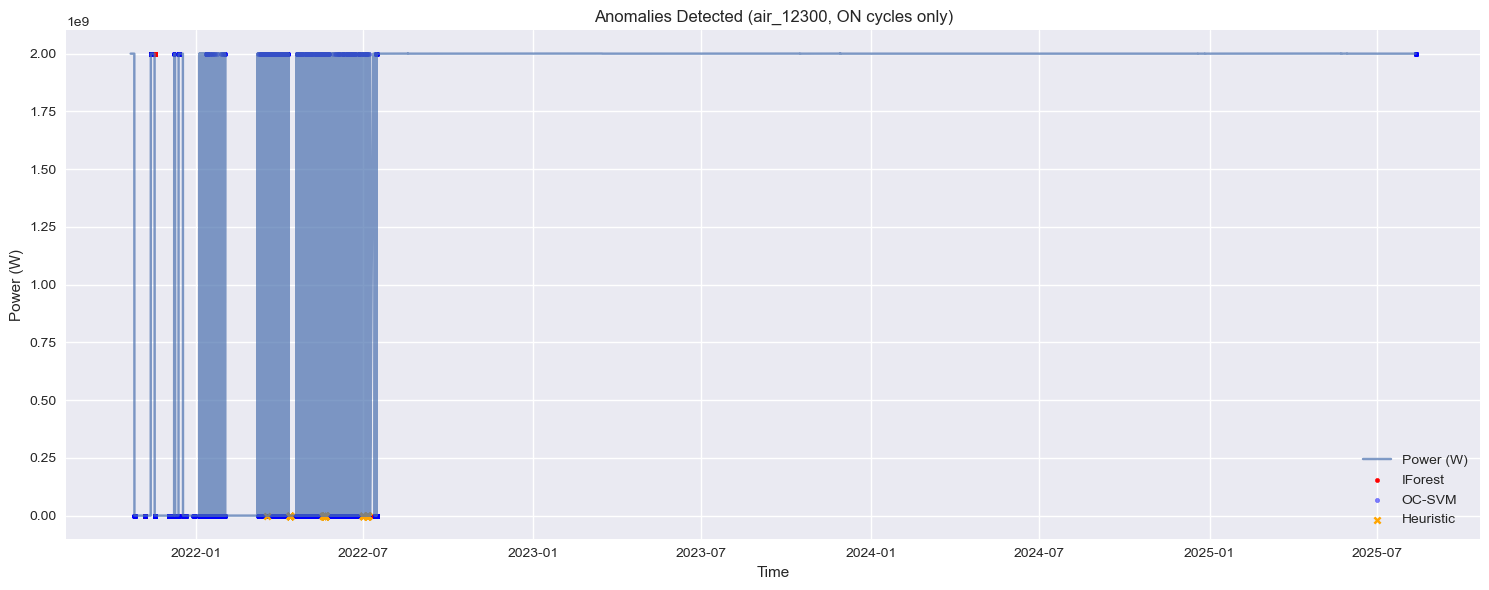

In [12]:
# Visualize anomalies on top of power curve
plt.figure(figsize=(15, 6))
plt.plot(df_on['time'], df_on['ptot_W'], label="Power (W)", alpha=0.7)

# Overlay anomalies
plt.scatter(df_on.loc[df_on['anomaly_iforest'] == 1, 'time'],
            df_on.loc[df_on['anomaly_iforest'] == 1, 'ptot_W'],
            color='red', s=10, label='IForest')

plt.scatter(df_on.loc[df_on['anomaly_ocsvm'] == 1, 'time'],
            df_on.loc[df_on['anomaly_ocsvm'] == 1, 'ptot_W'],
            color='blue', s=10, label='OC-SVM', alpha=0.5)

plt.scatter(df_on.loc[df_on['anomaly_heuristic'] == 1, 'time'],
            df_on.loc[df_on['anomaly_heuristic'] == 1, 'ptot_W'],
            color='orange', s=20, label='Heuristic', marker='x')

plt.legend()
plt.title("Anomalies Detected (air_12300, ON cycles only)")
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.tight_layout()
plt.show()

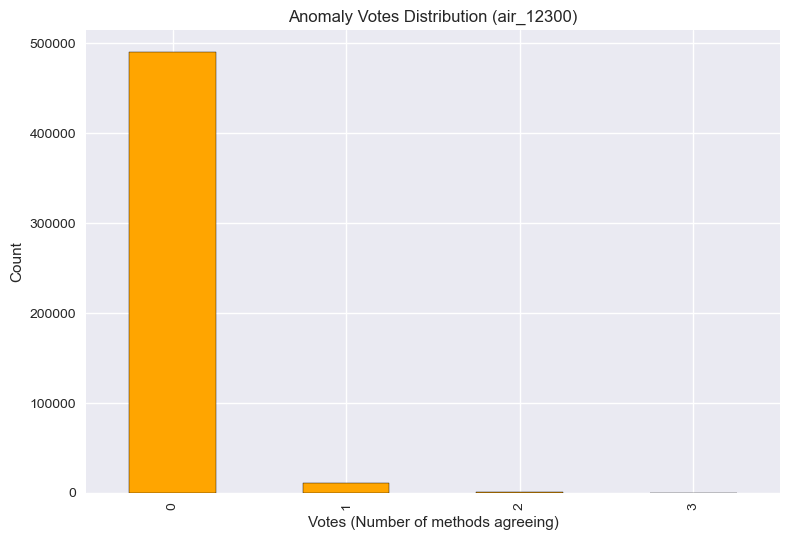

In [13]:
# Anomaly distribution bar chart
anomaly_summary = df_on['anomaly_votes'].value_counts().sort_index()

anomaly_summary.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Anomaly Votes Distribution (air_12300)")
plt.xlabel("Votes (Number of methods agreeing)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 6. Save Results

In [14]:
import os

# Save dataset with anomaly columns
processed_dir = "../../data/processed"
out_path_parquet = os.path.join(processed_dir, "air_12300_with_anomalies.parquet")
out_path_csv = os.path.join(processed_dir, "air_12300_with_anomalies.csv")

# Make sure votes exist
if 'anomaly_votes' not in df.columns:
    df['anomaly_votes'] = df[methods].sum(axis=1)

df.to_parquet(out_path_parquet, index=False)
df.to_csv(out_path_csv, index=False)

print("✅ Saved dataset with anomalies:")
print(f"  - {out_path_parquet}")
print(f"  - {out_path_csv}")
print(f"\nAnomaly columns: {[c for c in df.columns if 'anomaly' in c]}")

✅ Saved dataset with anomalies:
  - ../../data/processed\air_12300_with_anomalies.parquet
  - ../../data/processed\air_12300_with_anomalies.csv

Anomaly columns: ['pf_anomaly', 'pf_anomaly_rollmean', 'pf_anomaly_rollstd', 'anomaly_iforest', 'anomaly_ocsvm', 'anomaly_heuristic', 'anomaly_votes']


## Summary

Anomaly detection completed for **air_12300**:
- ✅ Isolation Forest (unsupervised)
- ✅ One-Class SVM (unsupervised)
- ✅ Heuristic rules (domain-based)
- ✅ Voting ensemble (0-3 votes)

**Next step**: Run `CNN_LSTM_12300.ipynb` to train the predictive maintenance model.